We work with the simulated example suggested by Jose, where we have a graph grid, say, and a periodic subgraph that moves around the graph and pulses. The hope is that we can capture periodicity with our pipeline; we also want to investigate how maximum persistence changes with the parameters of the sliding window embedding that we choose.

Perhaps we can consider this as migration data or something? population of a migrating species

# Description of the simulation

## Setup

In [34]:
from __future__ import division
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import squareform
shared_scripts_path = os.path.expanduser('~/projects/Research/dynamic_networks/shared_scripts/')
pyRipser_path = os.path.expanduser('~/projects/Research/dynamic_networks/pyRipser/')
sys.path.append(shared_scripts_path)
sys.path.append(pyRipser_path)
import graph_fns as gf
import persistence_fns as pf
import sliding_window_fns as sw
import TDA as r
import TDAPlotting as tdap
import dionysus as dns
from sklearn import manifold

# Dynamic Network

In [21]:
def phi_fn(x):
    return np.array([np.exp(-a + 5) for a in x])


# generate the blinking graph
K = 10
nPeriods = 5
Translen = 10 # determines the resolution of the dynamic network
graph = gf.getBlinkingVideo(K, nPeriods, Translen)
node_wts, adjacency_matrix, idx2pos, pos2idx = graph['XRet'], graph['A'], graph['idx2pos'], \
    graph['idx2pos']
edge_wts = [squareform(adjacency_matrix.toarray())] * len(node_wts)

## Visualize the dynamic network

In [160]:
# make a video or at least visualize a few of the graphs
import networkx as nx

def draw_graph_nodes(graph_node_wts,filename):
    # visualize the first graph
    nodes = graph_node_wts

    G = nx.Graph()

    # draw a grid graph
    for i in range(K):
        for j in range(K):
            # add node weight attribute + location
            G.add_node(K*i + j, pos = (i,j),weight = nodes[K*i+j])

    # color the node weights with a scale, and adjust their size
    
    # visualize the first graph
    pos = nx.get_node_attributes(G,'pos')
    weights = list(nx.get_node_attributes(G,'weight').values())
    node_sizes = [400*w + 200 for w in weights]
    
    
    plt.figure(figsize = (10,10))
    
    cmap = plt.cm.viridis
    nx.draw(G,pos,node_color = weights,
            node_size = node_sizes, cmap=cmap,
            edgecolors = 'black', linewidths = 0.5)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    plt.colorbar(sm, shrink = 0.75)
    
    plt.savefig(filename)
    plt.clear()

In [162]:
for i in range(len(node_wts)):
    draw_graph_nodes(node_wts[i],filename="Images/Simulated_Movie/image%05d"%i)

/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [168]:
import cv2
import os

image_folder = 'Images/Simulated_Movie'
video_name = 'dynamic_network_example.avi'

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith('png')]

frame = cv2.imread(os.path.join(image_folder, images[0])) 
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# third param is fps
video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

# Apply Pipeline

In [22]:
# pass thru the phi fn
phi_node_wts, phi_edge_wts = gf.weight_fn(node_wts, edge_wts, lamda=1, phi=phi_fn)

# get a valid filtration where w(x, y)= max(wv(x), wv(y), we(x, y))
filtration_matrix = list(map(lambda n, e: pf.get_filtration(n, e), phi_node_wts, phi_edge_wts))

# get the rips complexes from the filtration
rips = list(map(pf.get_rips_complex, filtration_matrix))

# get the H0 barcode
hom = list(map(dns.homology_persistence, rips))
dgms = list(map(lambda h, r: dns.init_diagrams(h, r)[0], hom, rips))
barcodes = [[[point.birth, point.death] for point in dgm] for dgm in dgms]

# get bottleneck distance between all the H0 diagrams;
bn_dist_matrix = pf.get_bottleneck_dist_matrix(barcodes)

## Sliding Window Embedding

In [23]:
# run sliding window and find the distance between sliding window vec
# find sliding window indices and then using the bottleneck dist matrix, find dist matrix
# of the sw vectors
d = 5
tau = 3
sw_vecs_indices = sw.sliding_window(range(len(barcodes)), d=2, tau=2)
sw_dist_matrix = sw.sw_distance_matrix(sw_vecs_indices, bn_dist_matrix)

# get H1 from the sliding window distance matrix
PDs = r.doRipsFiltrationDM(sw_dist_matrix, maxHomDim=2, coeff=2)


In [24]:
# check using MDS

# get mds coords
mds = manifold.MDS(n_components=3, n_init=4, dissimilarity='precomputed', metric=True)
mds_coords = mds.fit_transform(sw_dist_matrix)
x, y, z = np.split(mds_coords, 3, axis=1)


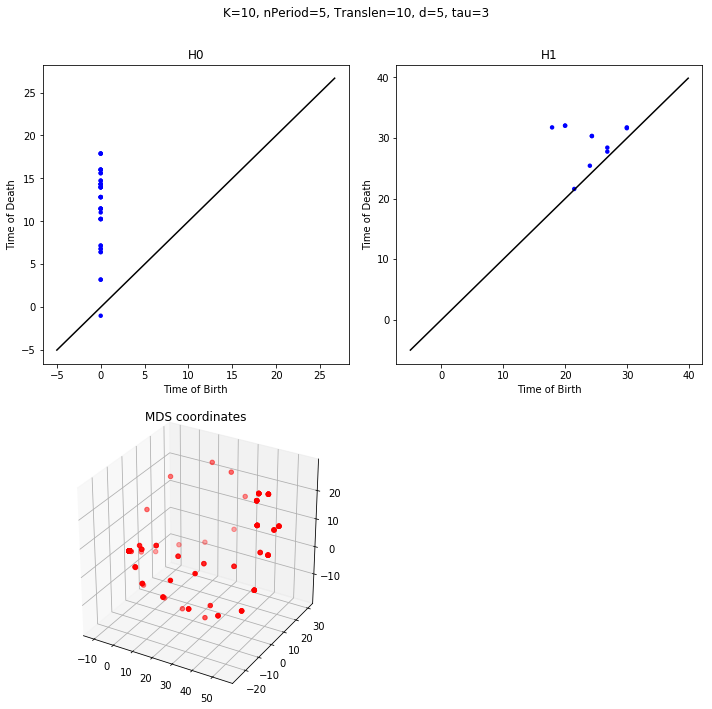

In [26]:
# plot
fig = plt.figure(figsize = (10,10))
plt.suptitle('K=%d, nPeriod=%d, Translen=%d, d=%d, tau=%d' % (K, nPeriods, Translen, d, tau))
ax = fig.add_subplot(221)
plt.title('H0')
tdap.plotDGM(PDs[0])

ax1 = fig.add_subplot(222)
plt.title('H1')
tdap.plotDGM(PDs[1])

ax3 = fig.add_subplot(223, projection='3d')
plt.title('MDS coordinates')
ax3.scatter(x, y, z, c='r')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [231]:
def get_maximum_persistence(PD):
    num_dim = len(PD)

    #has to be a 2D array
    def max_pers(array): 
        if len(array) == 0:
            return 0
        diff = array[:,1] - array[:,0]
        return max(diff)

    return list(map(max_pers,PD))

# gets the difference between the persistences of the first and second top features
def get_top_diff_persistence(PD):
    num_dim = len(PD)
    
    def get_diff(array):
        if len(array) == 0:
            return 0
        diff = array[:,1] - array[:,0]
        sorted_diff = sorted(diff,reverse = True)
        if len(sorted_diff) == 1:
            return sorted_diff[0]
        else:
            return sorted_diff[0] - sorted_diff[1]
        
    return(list(map(get_diff,PD)))
        
def get_num_features(PD):
    return(list(map(len,PD)))

# Dependence on parameters
Want to make plots of maxpers vs. parameters like dimension, window size, and sampling rate / noise.

In [226]:
# wrap up construction of dynamic network and pipeline into one function

# translen determines the resolution of the dynamic network
def construct_dynamic_network(K = 10,nperiods = 5, Translen = 10):
    graph = gf.getBlinkingVideo(K, nPeriods, Translen)
    
    node_wts, adjacency_matrix, idx2pos, pos2idx = graph['XRet'], graph['A'], graph['idx2pos'], \
        graph['idx2pos']
        
    edge_wts = [squareform(adjacency_matrix.toarray())] * len(node_wts)
    
    return((node_wts, edge_wts))


def apply_pipeline(node_wts,edge_wts, d = 5, tau = 3):
    
    # apply phi functions, and scale the weights
    phi_node_wts, phi_edge_wts = gf.weight_fn(node_wts, edge_wts, lamda=1, phi=phi_fn)

    # constrcut the filtrations / simplicial complexes according to our construction
    filtration_matrix = list(map(lambda n, e: pf.get_filtration(n, e), phi_node_wts, phi_edge_wts))
    rips = list(map(pf.get_rips_complex, filtration_matrix))
    
    # summarize these filtrations using H_0 barcodes
    hom = list(map(dns.homology_persistence, rips))
    dgms = list(map(lambda h, r: dns.init_diagrams(h, r)[0], hom, rips))
    barcodes = [[[point.birth, point.death] for point in dgm] for dgm in dgms]

    # get bottleneck distance between all the H0 diagrams;
    bn_dist_matrix = pf.get_bottleneck_dist_matrix(barcodes)
    
    # construct a sliding window embedding
    sw_vecs_indices = sw.sliding_window(range(len(barcodes)), d=d, tau=tau)
    sw_dist_matrix = sw.sw_distance_matrix(sw_vecs_indices, bn_dist_matrix)

    # get H1 from the sliding window distance matrix
    PDs = r.doRipsFiltrationDM(sw_dist_matrix, maxHomDim=1, coeff=2)
    
    return PDs


## Max Pers vs. window size

As a reminder, the window-size is the quantity $M \tau$ where $M$ is the embedding dimension and $\tau$ is the sampling rate. We keep track of both the max pers and the difference with netween the first and second highest H1 features, maybe also the number of features?

In [186]:
(node_wts,edge_wts) = construct_dynamic_network(K = 10, nperiods = 5, Translen = 5)

In [308]:
len(node_wts)

200

In [316]:
tau_test_values = range(7,12)
dim_test_values = range(2,25)

mpers_results = np.zeros((len(tau_test_values),len(dim_test_values)))
top_diff_results = np.zeros((len(tau_test_values),len(dim_test_values)))
len_results = np.zeros((len(tau_test_values),len(dim_test_values)))

for tau in tau_test_values:
    for d in dim_test_values:
        print(tau,d)
        
        PDs = apply_pipeline(node_wts,edge_wts, d = d, tau = tau) # get the PDs
        res = (get_maximum_persistence(PDs)[1],get_top_diff_persistence(PDs)[1], get_num_features(PDs)[1])
        print(res)
        
        mpers_results[tau - min(tau_test_values),d - min(dim_test_values)] = res[0]
        top_diff_results[tau - min(tau_test_values),d - min(dim_test_values)] = res[1]
        len_results[tau - min(tau_test_values),d - min(dim_test_values)] = res[2]

7 2
(60.9861, 54.562800000000003, 4)
7 3
(80.663200000000003, 74.458699999999993, 5)
7 4
(109.08019999999999, 103.5968, 5)
7 5
(116.065, 110.58160000000001, 5)
7 6
(118.49170000000001, 107.40690000000001, 6)
7 7
(119.134, 97.455399999999997, 8)
7 8
(121.76700000000001, 98.135700000000014, 11)
7 9
(121.76700000000001, 106.75380000000001, 13)
7 10
(122.264, 107.2508, 17)
7 11
(80.355999999999995, 69.689999999999998, 17)
7 12
(47.222999999999985, 37.725999999999999, 15)
7 13
(14.121999999999986, 2.5879999999999939, 11)
7 14
(14.730000000000018, 0.94300000000001205, 9)
7 15
(20.701999999999998, 9.5649999999999977, 7)
7 16
(14.826999999999998, 9.4799999999999898, 3)
7 17
(13.212000000000018, 8.8250000000000171, 3)
7 18
(11.253000000000014, 8.8750000000000284, 2)
7 19
(0, 0, 0)
7 20
(0, 0, 0)
7 21
(0.81200000000001182, 0.81200000000001182, 1)
7 22
(0.81200000000001182, 0.81200000000001182, 1)
7 23
(0, 0, 0)
7 24
(0, 0, 0)
8 2
(60.9861, 52.4572, 3)
8 3
(75.756699999999995, 67.227800000000002,

IndexError: list index out of range

In [ ]:
plt.gcf().clear()

plt.figure(figsize = (10,10))

plt.imshow(mpers_results)
plt.xlabel("dimension")
plt.xticks(np.arange(len(dim_test_values)),labels = list(dim_test_values))

plt.ylabel("tau")
plt.yticks(np.arange(len(tau_test_values)), labels = list(tau_test_values))

plt.title("Max Pers vs. Embedding Dimension and Sampling Rate")

plt.colorbar(shrink = 0.5)

plt.show()



In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.gcf().clear()
fig, axs = plt.subplots(2,1, figsize = (7,7))

im1 = axs[0].imshow(mpers_results)

axs[0].set_xlabel('dimension')
axs[0].set_xticks(np.arange(len(dim_test_values)))
axs[0].set_xticklabels(labels = list(dim_test_values))

axs[0].set_ylabel('tau')
axs[0].set_yticks(np.arange(len(tau_test_values)))
axs[0].set_yticklabels(labels = list(tau_test_values))

axs[0].set_title('Max Pers.')

divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1,cax1,orientation = 'vertical')

### Do the other plot ###

im2 = axs[1].imshow(np.divide(top_diff_results,mpers_results),cmap = plt.cm.magma)

axs[1].set_xlabel('dimension')
axs[1].set_xticks(np.arange(len(dim_test_values)))
axs[1].set_xticklabels(labels = list(dim_test_values))


axs[1].set_ylabel('tau')
axs[1].set_yticks(np.arange(len(tau_test_values)))
axs[1].set_yticklabels(labels = list(tau_test_values))
axs[1].set_title('Ratio of Pers. Diff. vs. Max Pers.')

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2,cax2)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.suptitle('Max Persistence vs. tau and d', fontsize = 15)
plt.savefig('Maxpers_and_ratio')
plt.show()

In [314]:
np.save('maxpers_array_6_32',mpers_results)
np.save('topdiff_array_6_32',top_diff_results)
np.save('pd_length_array_6_32',len_results)